# Feasibility study

In our feasibility study we want to test if the sensor value distributions are different for combinations of holds.

To do this, we first import libraries and the data we recorded for the feasibility study on April 23.

In [1]:
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.stats import ks_2samp
import seaborn as sns
from sklearn.decomposition import PCA

from script.helpers import get_data

In [2]:
X, holds, _ = get_data(dates=['0423'])

## Dimensionality reduction

Our dataset is eight-dimensional but we need to conduct our hypothesis testing on one-dimensional data.
To take all eight sensors into account instead of just selecting one, we test along the axis of highest variance, i.e. the first principal component.

Note that we fit the Principal Component Analysis to only the data where a hold was being held by omitting all idle data points.

In [3]:
pca = PCA(n_components=1)
pca.fit(X[holds != 'idle'])
X['PCA1'] = pca.transform(X)

Now that we have computed reduced one-dimensional data, we can look at histograms for the different holds.

array([[<Axes: title={'center': 'crimp_20mm'}>,
        <Axes: title={'center': 'crimp_45mm'}>],
       [<Axes: title={'center': 'idle'}>,
        <Axes: title={'center': 'jug'}>],
       [<Axes: title={'center': 'sloper_35deg'}>, <Axes: >]], dtype=object)

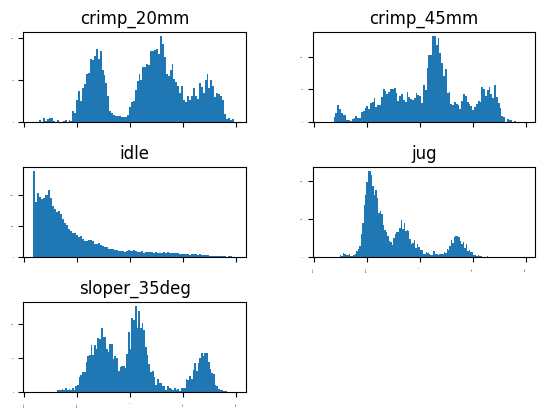

In [4]:
X.PCA1.hist(by=holds, bins=100, xlabelsize=0, ylabelsize=0, sharex=True)

Here, we see that we cannot assume a normal distribution in our data, which is why we opt for the non-parametric Kolmogorov-Smirnov test in the following.

## Testing

We conduct a two-sided Kolmogorov-Smirnov test for all pairs of holds and the idle position.
Therefore, our null-hypothesis is that the data for the two given holds originates from the same underlying distribution.

We want to test our hypothesis with a confidence level of 95%. Since we are however testing multiple hypotheses, i.e. one for each combination of holds and the idle position, we have to account for the multiple comparisons problem. We do this by applying a Bonferroni Correction and dividing our rejection threshold by the number of tests we will conduct.

In [5]:
hold_types = pd.Categorical(holds).categories
alpha = 0.95
threshold = (1 - alpha) / binom(len(hold_types), 2)
print('Bonferroni-corrected rejection threshold:')
print(f'  p < {threshold:.4f}  ⇔  -log(p) > {-np.log(threshold):.2f}')

Bonferroni-corrected rejection threshold:
  p < 0.0050  ⇔  -log(p) > 5.30


In [6]:
results = np.ones((len(hold_types), len(hold_types)))
for i, hold1 in enumerate(hold_types):
    for j, hold2 in enumerate(hold_types):
        if i <= j: continue
        results[i, j] = ks_2samp(X.PCA1[holds == hold1], X.PCA1[holds == hold2]).pvalue

We visualize the testing results as a heatmap of the negative logarithm of the p-value, i.e. the probability that the data of the given combination was drawn from the same underlying distribution

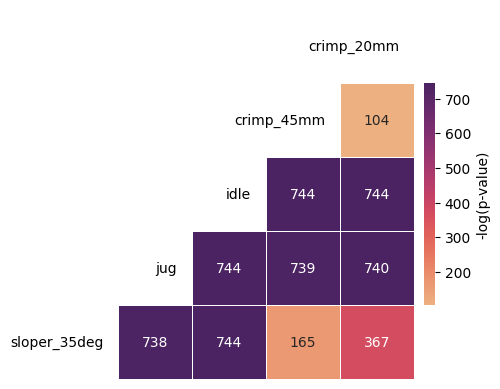

In [7]:
up_triang = np.triu(np.ones_like(results)).astype(bool)
ax = sns.heatmap(
    -np.log(results + np.nextafter(0, 1)),
    cmap='flare', xticklabels=False, yticklabels=False,
    annot=True, fmt='.0f',
    square=True, linecolor='white', linewidths=0.5,
    cbar=True, mask=up_triang, cbar_kws={'shrink': 0.6, 'pad': 0.02, 'label': '-log(p-value)'}
)
ax.invert_xaxis()
for i, label in enumerate(hold_types):
    ax.text(i + 0.2, i + 0.5, label, ha='right', va='center')

We can see that all pairs of holds have very small p-values which are easily rejected at our computed threshold.

This means we can reject all hypotheses and have shown that all pairs of holds and the idle position produce data from significantly different distributions.